<a href="https://colab.research.google.com/github/stixmal/praktikum_project_ds/blob/main/%D0%9F%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81%20%D0%B2%D0%BE%D1%81%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%BE%D0%BB%D0%BE%D1%82%D0%B0%20%D0%B8%D0%B7%20%D1%80%D1%83%D0%B4%D1%8B/gold_recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Моделирование процесса восстановления золота из руды

Подготовили прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель предсказывает коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении сырые данные, выгруженные из хранилища, с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.  

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.  

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
Предварительно проверили данные на корректность.  

Источники данных:  

+ `/datasets/gold_recovery_train.csv` - обучающая выборка
+ `/datasets/gold_recovery_test.csv` - тестовая  выборка
+ `/datasets/gold_recovery_full.csv` - исходные данные.

## Оглавление

### [1. Подготовка данных](#1) <a id='10'></a>   


+ [1.1 Изучение файлов](#1.1) 


+ [1.2 Проверка эффективности обогащения](#1.2) 


+ [1.3 Предобработка данных](#1.3) 


### [2. Анализ данных](#2) <a id='20'></a>

+ [2.1 Концентрация металлов на разных этапах очистки](#2.1) 


+ [2.2 Распределение гранул сырья](#2.2) 


+ [2.3 Суммарная концентрация веществ на разных стадиях](#2.3) 

### [3. Построение модели](#3) <a id='30'></a>

+ [3.1 Функция для вычисления итоговой sMAPE](#3.1) 


+ [3.2 Обучение и проверка модели](#3.2) 


***

## 1. Подготовка данных <a id='1'></a>   [^](#10) 

* ### 1.1 Изучение файлов <a id='1.1'></a> [^](#10)

In [ ]:
# импорт библиотеки pandas и numpy
import pandas as pd 
import numpy as np  

# импорт модуля display
from IPython.display import display  

# импорт библиотеки mathplot и seaborn
import matplotlib.pyplot as plt
import seaborn as sns 

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore') 

# импорт mae
from sklearn.metrics import mean_absolute_error

# импорт модели линейной регрессии
from sklearn.linear_model import LinearRegression

# импорт модели случайного леса
from sklearn.ensemble import RandomForestRegressor

# импорт сетки гиперпараметров
from sklearn.model_selection import GridSearchCV

# импорт make_score
from sklearn.metrics import make_scorer

# импорт метрик
from sklearn.metrics import r2_score

In [ ]:
# чтение файлов с данными
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [ ]:
# визуальный осмотр признаков 
df_train.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

В тестовой выборке отсутствуют некоторые признаки.

In [ ]:
df_train.shape, df_test.shape

((16860, 87), (5856, 53))

In [ ]:
# исходные данные поделены 75 на 25 %
df_train.shape[0] / df_full.shape[0]

0.7422081352350766

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

Видим, что в датасетах имеются пропуски, в дальнейшем нужно думать о методе их заполнения. Также имеется колонка со временем, хронологически-последовательным технологическим процессам. 

* ### 1.2 Проверка эффективности обогащения <a id='1.2'></a> [^](#10)

Написали функцию для определения эффективности.

In [ ]:
# C — доля золота в концентрате после флотации/очистки;
# F — доля золота в сырье/концентрате до флотации/очистки;
# T — доля золота в отвальных хвостах после флотации/очистки.
# ограничили проценты от 0 до 100

def recovery(C, F, T):
    recov = ((C * (F - T)) / (F * (C - T))) * 100
    recov[recov<0] = np.nan
    recov[recov>100] = np.nan
    return recov

In [ ]:
# расчёт эффективности обогащения чернового концентрата
C, F, T = df_train['rougher.output.concentrate_au'], df_train['rougher.input.feed_au'],  df_train['rougher.output.tail_au']
rec = recovery(C, F, T)

In [ ]:
# описание данных об эффективности
rec.describe(), df_train['rougher.output.recovery'].describe()

(count    14287.000000
 mean        82.394201
 std         15.096808
 min         -0.000000
 25%         79.818372
 50%         85.235997
 75%         90.131691
 max        100.000000
 dtype: float64,
 count    14287.000000
 mean        82.394201
 std         15.096808
 min          0.000000
 25%         79.818372
 50%         85.235997
 75%         90.131691
 max        100.000000
 Name: rougher.output.recovery, dtype: float64)

In [ ]:
# вычисление mae по исходным и посчитанным данным с заменой пропущенных значенией 

mean_absolute_error(df_train['rougher.output.recovery'].fillna(method='ffill'), rec.fillna(method='ffill'))

9.514308413213554e-15

Средняя абсолютная ошибка очень мала, поэтому будем считать, что эффективность посчитана верно.

* ### 1.3 Предобработка данных <a id='1.3'></a> [^](#10)

In [ ]:
# отсутствующие признаки в тестовой выборке
set(df_train.columns) - set(df_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке отсутствуют признаки output - так как это скорее всего целевые признаки. Признаки calculation возможно показывают расчет де факто после всех степеней очистки и переработки руды.

In [ ]:
# просмотр пропущенных значений тренировочной выборки
df_train.isna().sum().sort_values(ascending=False).head(10)

rougher.output.recovery               2573
rougher.output.tail_ag                2250
rougher.output.tail_sol               2249
rougher.output.tail_au                2249
secondary_cleaner.output.tail_sol     1986
rougher.input.floatbank11_xanthate    1904
final.output.recovery                 1521
primary_cleaner.input.sulfate         1307
primary_cleaner.input.depressant      1262
rougher.calculation.au_pb_ratio       1242
dtype: int64

In [ ]:
# просмотр пропущенных значений тестовой выборки
df_test.isna().sum().sort_values(ascending=False).head(10)

rougher.input.floatbank11_xanthate          353
primary_cleaner.input.sulfate               302
primary_cleaner.input.depressant            284
rougher.input.floatbank10_sulfate           257
primary_cleaner.input.xanthate              166
rougher.input.floatbank10_xanthate          123
rougher.input.feed_sol                       67
rougher.input.floatbank11_sulfate            55
rougher.input.feed_rate                      40
secondary_cleaner.state.floatbank3_a_air     34
dtype: int64

На тестовой выборке заметно меньше пропущенных значений. В тренировочной отсутствующих значений гораздо больше.  

Удалили признаки, которых нет в тестовой выборке, выделили целевой признак, а также разделили технический процесс флотации и очистки, так как они мало кореллируют между собой. В качестве целевого признака будем предсказывать эффективность обогащения металла после  процесса очистки. 

In [ ]:
# удаление признаков, отсутствующих в тестовой выборке
df_train = df_train.loc[:,  df_test.columns]

# выделение целевого признака в процессе флотации и финальной очистки 
target_train_rougher = df_full.loc[df_full['date'].isin(df_train['date']), ['rougher.output.recovery']]
target_train_cleaner = df_full.loc[df_full['date'].isin(df_train['date']), ['final.output.recovery']]

# признаки в процессе флотации и финальной очистки обучающей выборки
features_train_rougher = df_train.loc[:, df_train.columns.str.contains('rougher')]
features_train_cleaner = df_train.loc[:, df_train.columns.str.contains('cleaner')]

# выделение целевого признака в процессе флотации и финальной очистки 
target_test_rougher = df_full.loc[df_full['date'].isin(df_test['date']), ['rougher.output.recovery']]
target_test_cleaner = df_full.loc[df_full['date'].isin(df_test['date']), ['final.output.recovery']]

# признаки в процессе флотации и финальной очистки тестовой выборки
features_test_rougher = df_test.loc[:, df_test.columns.str.contains('rougher')]
features_test_cleaner = df_test.loc[:, df_test.columns.str.contains('cleaner')]

In [ ]:
# проверка обучающей выборки после флотации
features_train_rougher.shape, target_train_rougher.shape

((16860, 22), (16860, 1))

In [ ]:
# проверка обучачающей выборки после финальной очистки
features_train_cleaner.shape, target_train_cleaner.shape

((16860, 30), (16860, 1))

In [ ]:
# проверка тестовой выборки
features_test_rougher.shape, target_test_rougher.shape

((5856, 22), (5856, 1))

In [ ]:
features_test_cleaner.shape, target_test_cleaner.shape

((5856, 30), (5856, 1))

### Вывод  

Выборки поделены согласно технологическому процессу, выделены целевые признаки, удалены избыточные и данные готовы к дальнейшему анализу.

***

## 2. Анализ данных <a id='2'></a>   [^](#10) 

* ### 2.1 Концентрация металлов на разных этапах очистки <a id='2.1'></a> [^](#10)

Посмотрели на концентрацию металлов на различных этапах очистки.

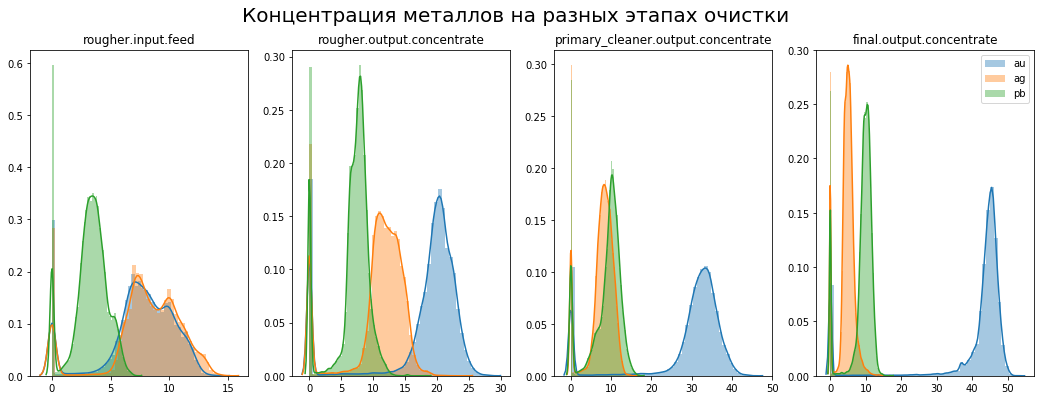

In [ ]:
# создали список с концентрациями после каждого технологического этапа
process = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']

# список с металлами
metals = ['au', 'ag', 'pb']

fig, axs = plt.subplots(1, 4, figsize=(18, 6))
fig.suptitle('Концентрация металлов на разных этапах очистки', fontsize=20)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    for metal in metals:        
        sns_ax = sns.distplot(df_full.loc[:, df_full.columns.str.contains(stage+'_'+metal)].dropna(), label=metal, ax=ax)    
plt.legend()

Мы наблюдаем, что концентрация золота после каждого этапа очистки значительно возрастает, в отличие от других металлов. Также хорошо видны выбросы возле нуля. Скорее всего они нуждаются в удалении, так как из нулевой концентрации мало можно получить полезной выработки.

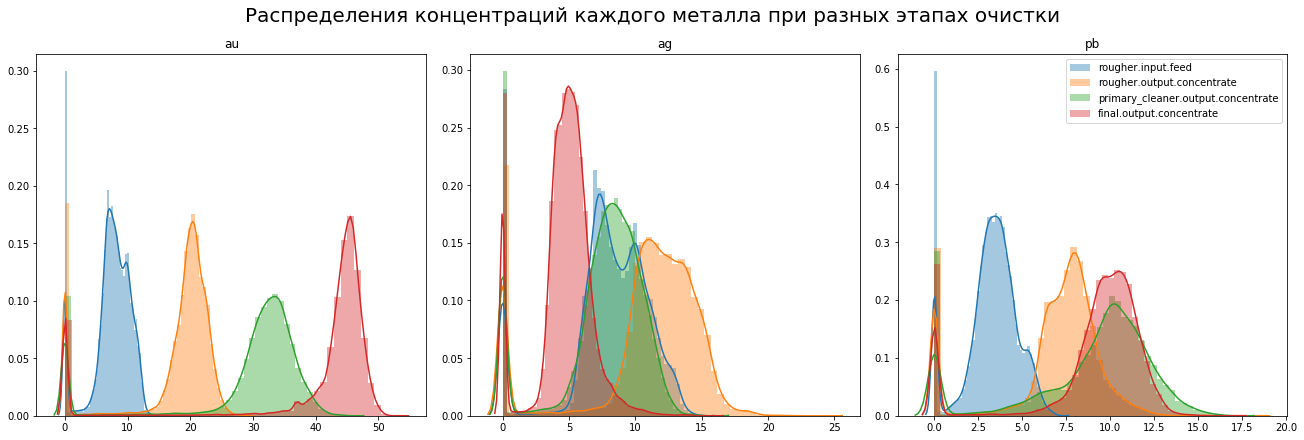

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
fig.suptitle('Распределения концентраций каждого металла при разных этапах очистки', fontsize=20)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process:
        plt_ax = sns.distplot(df_full.loc[:, df_full.columns.str.contains(stage+'_'+metal)].dropna(), label=stage, ax=ax)   
plt.legend()

Вывод: однозначно распределения концентраций явно увеличиваются у золота.

* ### 2.2 Распределение гранул сырья <a id='2.2'></a> [^](#10)

Посмотрели как распределяются гранулы сырья на обучающей и тестовой выборке.

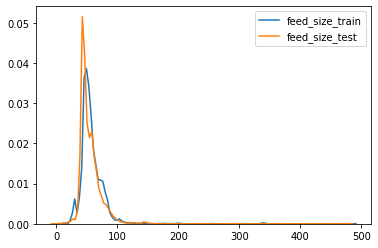

In [ ]:
sns.kdeplot(df_train['rougher.input.feed_size'].dropna(), label='feed_size_train')
sns.kdeplot(df_test['rougher.input.feed_size'].dropna(), label='feed_size_test')
plt.legend()

Мы видим, что распределения очень похожи. Оценка модели должна быть адекватной.

* ### 2.3 Суммарная концентрация веществ на разных стадиях <a id='2.3'></a> [^](#10)

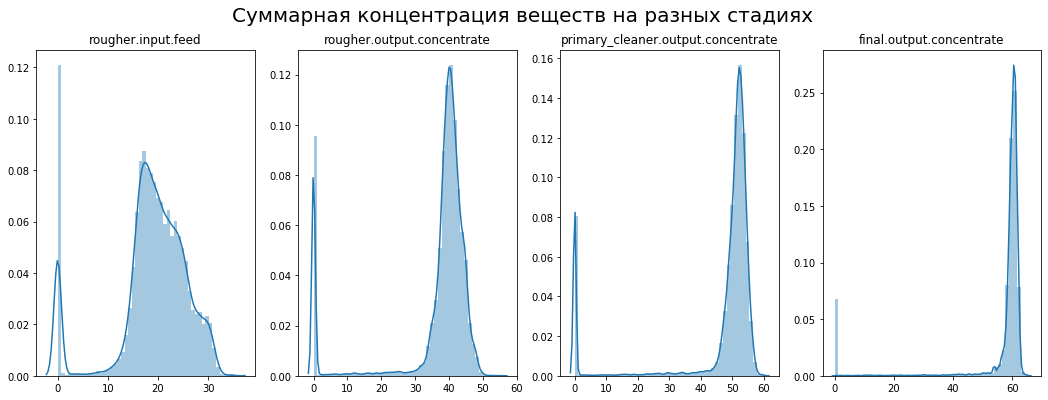

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
fig.suptitle('Суммарная концентрация веществ на разных стадиях', fontsize=20)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    sum_full = df_full[stage+ '_ag'] + df_full[stage+ '_au'] + df_full[stage+ '_pb']
    sns.distplot(sum_full.dropna(), label='full', ax=ax)

Видим, что имеются суммарные выбросы около нуля. Имеет смысл удалить околонулевые значения, так как они не имеют практического значения. 

### Вывод  

- концентрация золота после каждой степени очистки возрастает
- распределение гранул в обучающей и тестовой выборке похожи
- имеет смысл удалить околонулевые концентрации полезных веществ из-за низкого практического смысла.

In [ ]:
for stage in process:
    df_full = df_full.drop(df_full[(df_full[stage+'_ag'] < 1) + (df_full[stage+'_au'] < 1) + (df_full[stage+'_pb'] < 1)].index)

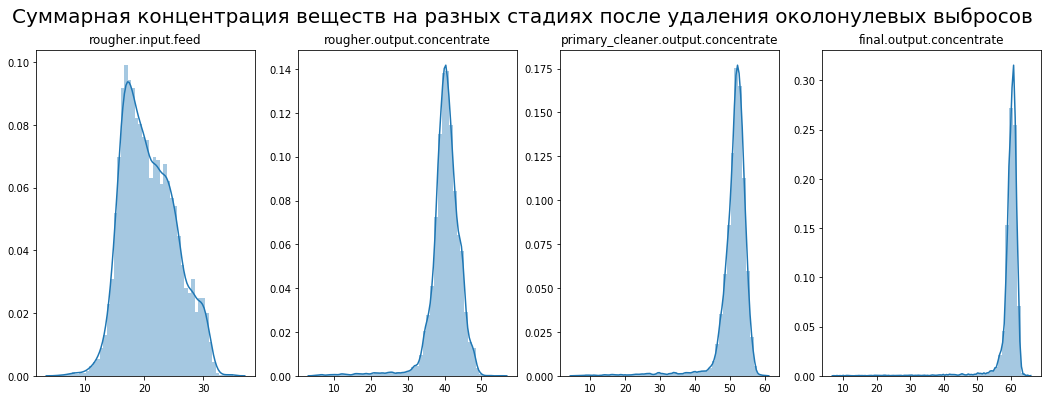

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
fig.suptitle('Суммарная концентрация веществ на разных стадиях после удаления околонулевых выбросов', fontsize=20)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    sum_full = df_full[stage+ '_ag'] + df_full[stage+ '_au'] + df_full[stage+ '_pb']
    sns.distplot(sum_full.dropna(), label='full', ax=ax)

***

## 3. Построение модели <a id='3'></a>   [^](#10) 

* ### 3.1 Функция для вычисления итоговой sMAPE <a id='3.1'></a> [^](#10)

Написали функцию для определения sMAPE.

In [ ]:
def smape(y, y_pred):
    y = y.values
    result = abs(y - y_pred) / ((abs(y) + abs(y_pred)) / 2)
    return 100 * result.mean()

In [ ]:
# финальный sMAPE
def final_smape(smape_rougher, smape_clear):
    result = (0.25 * smape_rougher) + (0.75 * smape_clear)
    return result

* ### 3.2 Обучение и проверка модели <a id='3.2'></a> [^](#10)

Заполнили предварительно пропуски.

Удалили нулевые значения в целевом признаке.

In [ ]:
# удаление пропусков в целевом признаке
target_train_rougher = target_train_rougher.dropna()
target_train_cleaner = target_train_cleaner.dropna()

# заполнение пропусков в признаках обучающей выборки
features_train_rougher = features_train_rougher.loc[target_train_rougher.index, :]
features_train_rougher = features_train_rougher.fillna(method='ffill')
features_train_cleaner = features_train_cleaner.loc[target_train_cleaner.index, :]
features_train_cleaner = features_train_cleaner.fillna(method='ffill')

In [ ]:
# удаление пропусков в целевом признаке
target_test_rougher = target_test_rougher.dropna()
target_test_cleaner = target_test_cleaner.dropna()

# заполнение пропусков в признаках тестовой выборки
features_test_rougher = features_test_rougher.loc[target_test_rougher.index, :]
features_test_rougher = features_test_rougher.fillna(method='ffill')
features_test_cleaner = features_test_cleaner.loc[target_test_cleaner.index, :]
features_test_cleaner = features_test_cleaner.fillna(method='ffill')

In [ ]:
# проверка выборок
target_train_rougher.shape, features_train_rougher.shape

((14287, 1), (14287, 22))

In [ ]:
target_train_cleaner.shape, features_train_cleaner.shape

((15339, 1), (15339, 30))

In [ ]:
target_test_rougher.shape, features_test_rougher.shape

((5310, 1), (5310, 22))

In [ ]:
target_test_cleaner.shape, features_test_cleaner.shape

((5414, 1), (5414, 30))

***

Создали функцию перебора гиперпараметров.

In [ ]:
# функция для оценки качества модели в GridSearch
my_scorer = make_scorer(score_func=smape, greater_is_better=False)

def grid_search(model, param_grid, cv, features_train, target_train):
    grid_model = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring=my_scorer, n_jobs=-1)
    grid_model.fit(features_train, target_train)
    best_estimator = grid_model.best_estimator_
    best_parameters = grid_model.best_params_
    best_score = grid_model.best_score_
    return best_estimator, best_parameters, best_score

In [ ]:
# сетка гиперпараметров линейной регрессии
param_grid_reg={'fit_intercept':[True, False],
                'normalize':[True, False]}

# сетка параметров случайного леса
param_grid_forest={'n_estimators':[25, 50],
                   'max_depth':[3, 4, 5],
                   'max_features': ['auto', 'sqrt']}

## Линейная регрессия

### `rougher`

In [ ]:
# определение лучшей модели после флотации 
lin_reg = LinearRegression()
grid_rougher_reg = grid_search(lin_reg, param_grid_reg, 5, features_train_rougher, target_train_rougher)
grid_rougher_reg

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True),
 {'fit_intercept': True, 'normalize': True},
 -12.49635431300769)

In [ ]:
# определение smape rougher
pred_rougher_reg = grid_rougher_reg[0].predict(features_test_rougher)
smape_rougher_reg = smape(target_test_rougher, pred_rougher_reg)
smape_rougher_reg

16.47241308963873

### `cleaner`

In [ ]:
# определение лучшей модели после финальной очистки
grid_cleaner_reg = grid_search(lin_reg, param_grid_reg, 5, features_train_cleaner, target_train_cleaner)
grid_cleaner_reg

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 {'fit_intercept': True, 'normalize': False},
 -12.909515011247407)

In [ ]:
# определение smape cleaner
pred_cleaner_reg = grid_cleaner_reg[0].predict(features_test_cleaner)
smape_cleaner_reg = smape(target_test_cleaner, pred_cleaner_reg)
smape_cleaner_reg

13.342064769892026

In [ ]:
# финальный smape
final_reg = final_smape(smape_rougher_reg, smape_cleaner_reg)
final_reg

14.124651849828702

## Случайный лес

### `rougher`

In [ ]:
# определение лучшей модели после флотации 
rfr = RandomForestRegressor(random_state=12345)
grid_rougher_forest = grid_search(rfr, param_grid_forest, 5, features_train_rougher, target_train_rougher)
grid_rougher_forest

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False),
 {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 25},
 -12.302188005105824)

In [ ]:
# определение smape rougher
pred_rougher_forest = grid_rougher_forest[0].predict(features_test_rougher)
smape_rougher_forest = smape(target_test_rougher, pred_rougher_forest)
smape_rougher_forest 

12.686170496400429

### `cleaner`

In [ ]:
# определение лучшей модели после финальной очистки
grid_cleaner_forest = grid_search(rfr, param_grid_forest, 5, features_train_cleaner, target_train_cleaner)
grid_cleaner_forest

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                       max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False),
 {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 25},
 -12.338027896633337)

In [ ]:
# определение smape cleaner
pred_cleaner_forest = grid_cleaner_forest[0].predict(features_test_cleaner)
smape_cleaner_forest = smape(target_test_cleaner, pred_cleaner_forest)
smape_cleaner_forest

14.12406502764964

In [ ]:
# финальный smape
final_forest = final_smape(smape_rougher_forest, smape_cleaner_forest)
final_forest

13.764591394837337

### Вывод  

Мы обучили линейную регрессия и случайный лес и нашли по сетке гиперпараметров лучшие модели, максимизирующие отрицательный smape. Также проверили на тестовой выборке их качество. Так как итоговый sMAPE случайного леса (13,764) оказался меньше, чем у линейной регрессии (14,125), то лучшей моделью является RandomForestRegressor.